In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as f

In [2]:
from torch.utils.data import DataLoader
from torchvision import datasets,transforms

In [3]:
import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
transform=transforms.ToTensor()

In [5]:
train_data=datasets.MNIST(root="../content/Data",train=True,download=True,transform=transform)

Failed to download (trying next):
HTTP Error 503: Service Unavailable




Extracting ../content/Data/MNIST/raw/train-images-idx3-ubyte.gz to ../content/Data/MNIST/raw

Failed to download (trying next):
HTTP Error 503: Service Unavailable




Extracting ../content/Data/MNIST/raw/train-labels-idx1-ubyte.gz to ../content/Data/MNIST/raw

Failed to download (trying next):
HTTP Error 503: Service Unavailable




Extracting ../content/Data/MNIST/raw/t10k-images-idx3-ubyte.gz to ../content/Data/MNIST/raw




Extracting ../content/Data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ../content/Data/MNIST/raw

Processing...
Done!


/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:502: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:143.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [6]:
test_data=datasets.MNIST(root="../content/Data",train=False,download=True,transform=transform)

In [44]:
train_data

Dataset MNIST
    Number of datapoints: 60000
    Root location: ../content/Data
    Split: Train
    StandardTransform
Transform: ToTensor()

In [45]:
test_data

Dataset MNIST
    Number of datapoints: 10000
    Root location: ../content/Data
    Split: Test
    StandardTransform
Transform: ToTensor()

In [46]:
image,label=train_data[0]

In [47]:
image.shape

torch.Size([1, 28, 28])

In [48]:
label

5

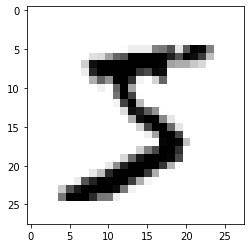

In [49]:
plt.imshow(image.reshape(28,28),cmap="gist_yarg")

In [70]:
train_loader=DataLoader(train_data,batch_size=5000,shuffle=True)
test_loader=DataLoader(test_data,batch_size=1000,shuffle=False)

In [71]:
from torchvision.utils import make_grid
np.set_printoptions(formatter=dict(int=lambda x: f'{x:4}'))

Labels:  [   9    9    3    8    5    8    2    1    4    8    9    9]


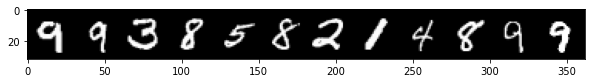

In [72]:
for images,labels in train_loader:
  break
print('Labels: ', labels[:12].numpy())
im = make_grid(images[:12], nrow=12)
plt.figure(figsize=(10,4))
plt.imshow(np.transpose(im.numpy(), (1, 2, 0)));

In [73]:
class MultilayerPerceptron(nn.Module):

  def __init__(self,in_size=784,out_size=10,layers=[128,84]):
    super().__init__()
    self.fc1=nn.Linear(in_size,layers[0])
    self.fc2=nn.Linear(layers[0],layers[1])
    self.fc3=nn.Linear(layers[1],out_size)
  
  def forward(self,x):
    x=f.relu(self.fc1(x))
    x=f.relu(self.fc2(x)) 
    x=self.fc3(x)
    return f.log_softmax(x,dim=1)   

In [106]:
model=MultilayerPerceptron()

In [107]:
model

MultilayerPerceptron(
  (fc1): Linear(in_features=784, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)

In [108]:
def count_parameters(model):
  params=[p.numel() for p in model.parameters() if p.requires_grad]
  for item in params:
    print(f"{item:>6}")
  print(f'______\n{sum(params):>6}')

In [109]:
count_parameters(model)

100352
   128
 10752
    84
   840
    10
______
112166


In [110]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [111]:
for images, labels in train_loader:
    print('Batch shape:', images.size())
    break

Batch shape: torch.Size([5000, 1, 28, 28])


In [112]:
images.view(100,-1).size()

torch.Size([100, 39200])

In [113]:
import time
start_time = time.time()

epochs = 10
train_losses = []
test_losses = []
train_correct = []
test_correct = []

for i in range(epochs):
  trn_correct=0
  tst_correct=0
  for b,(x_train,y_train) in enumerate(train_loader):
    b+=1
    y_pred=model(x_train.view(5000,-1))
    loss=criterion(y_pred,y_train)
    predicted=torch.max(y_pred.data,1)[1]
    batch_correct=(predicted==y_train).sum()
    trn_correct+=batch_correct
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    print(f'epoch: {i:2}  batch: {b:4} [{5000*b:6}/60000]  loss: {loss.item():10.8f}  accuracy: {trn_correct.item()*100/(5000*b):7.3f}%')
    train_losses.append(loss)
    train_correct.append(trn_correct)
    with torch.no_grad():
        for b, (x_test, y_test) in enumerate(test_loader):
          y_val = model(x_test.view(1000, -1))
          predicted = torch.max(y_val.data, 1)[1] 
          tst_correct += (predicted == y_test).sum()
    loss = criterion(y_val, y_test)
    test_losses.append(loss)
    test_correct.append(tst_correct)
    
print(f'\nDuration: {time.time() - start_time:.0f} seconds')


epoch:  0  batch:    1 [  5000/60000]  loss: 2.30505419  accuracy:   7.460%
epoch:  0  batch:    2 [ 10000/60000]  loss: 2.27774072  accuracy:   9.340%
epoch:  0  batch:    3 [ 15000/60000]  loss: 2.25352001  accuracy:  13.053%
epoch:  0  batch:    4 [ 20000/60000]  loss: 2.22347736  accuracy:  17.895%
epoch:  0  batch:    5 [ 25000/60000]  loss: 2.19297695  accuracy:  22.428%
epoch:  0  batch:    6 [ 30000/60000]  loss: 2.15663457  accuracy:  26.683%
epoch:  0  batch:    7 [ 35000/60000]  loss: 2.11425948  accuracy:  30.209%
epoch:  0  batch:    8 [ 40000/60000]  loss: 2.06702733  accuracy:  33.148%
epoch:  0  batch:    9 [ 45000/60000]  loss: 2.01482058  accuracy:  35.600%
epoch:  0  batch:   10 [ 50000/60000]  loss: 1.95669389  accuracy:  37.702%
epoch:  0  batch:   11 [ 55000/60000]  loss: 1.89209020  accuracy:  39.638%
epoch:  0  batch:   12 [ 60000/60000]  loss: 1.83178627  accuracy:  41.415%
epoch:  1  batch:    1 [  5000/60000]  loss: 1.76934803  accuracy:  62.120%
epoch:  1  b

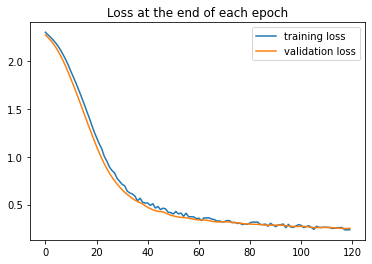

In [114]:
plt.plot(train_losses, label='training loss')
plt.plot(test_losses, label='validation loss')
plt.title('Loss at the end of each epoch')
plt.legend()

In [126]:
test_load_all = DataLoader(test_data, batch_size=10000, shuffle=False)

In [127]:
with torch.no_grad():
    correct = 0
    for X_test, y_test in test_load_all:
        y_val = model(X_test.view(len(X_test), -1)) 
        predicted = torch.max(y_val,1)[1]
        correct += (predicted == y_test).sum()
print(f'Test accuracy: {correct.item()}/{len(test_data)} = {correct.item()*100/(len(test_data)):7.3f}%')

Test accuracy: 9319/10000 =  93.190%


In [128]:
np.set_printoptions(formatter=dict(int=lambda x: f'{x:4}'))
print(np.arange(10).reshape(1,10))
print()
print(confusion_matrix(predicted.view(-1), y_test.view(-1)))

[[   0    1    2    3    4    5    6    7    8    9]]

[[ 963    0   10    2    1    8   12    2    7   12]
 [   0 1114    2    1    1    3    3    9    3    7]
 [   0    2  939   17    6    4    5   24    6    1]
 [   1    2   21  936    1   29    0    6   21   13]
 [   0    1    8    1  929   12    9    6   10   39]
 [   3    1    0   14    0  781    9    0   17    4]
 [   6    4   10    0   10   12  914    0   10    0]
 [   2    1   11   13    3    6    2  956   12   26]
 [   5   10   28   20    6   30    4    2  884    4]
 [   0    0    3    6   25    7    0   23    4  903]]


In [129]:
misses = np.array([])
for i in range(len(predicted.view(-1))):
    if predicted[i] != y_test[i]:
        misses = np.append(misses,i).astype('int64')
len(misses)

681

In [130]:
r = 12  
row = iter(np.array_split(misses,len(misses)//r+1))

Index: [   8   33   66   92  149  151  193  195  217  233  241  247]
Label: [   5    4    6    9    2    9    9    3    6    8    9    4]
Guess: [   6    6    2    4    9    8    3    8    5    7    8    2]


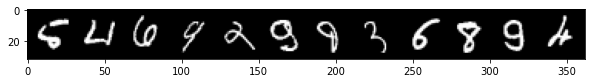

In [131]:
nextrow = next(row)
print("Index:", nextrow)
print("Label:", y_test.index_select(0,torch.tensor(nextrow)).numpy())
print("Guess:", predicted.index_select(0,torch.tensor(nextrow)).numpy())

images = X_test.index_select(0,torch.tensor(nextrow))
im = make_grid(images, nrow=r)
plt.figure(figsize=(10,4))
plt.imshow(np.transpose(im.numpy(), (1, 2, 0)))